# Problem
In the capacitated p-median problem there is a set of demand locations (customers) and a set of facility sites (medians). We have to select locations for p-facilities and select for every facility a disjunct subset of customers together with the facility so that the sum of service demands of customers do not exceed the service capacity of their facility and every customer belongs to exactly one facility. The aim is to minimize the total transportation costs while satisfying the demands of the customers from the facilities

## SPEA Algorithm

## NSGA2 Algorithm
1. Initialize a random population.
2. Create offspring population. (selection, crossover and mutation)
2.1. Crossover: For each facilities in one parent, search for the closest facility in the other parent and place the child facility in the middle of the two parent facilities. 2.2. Mutation: Change locations of the facilities according to a normal distribution.
2. Evaluate parents in a tournament selection by rank and crowding distance. (lexicographic order)
3. Select best parents for reproduction.

5. Evaluate offspring by rank and crowding distance.
6. Create new parents from best frontiers.

### Questions
- Should we implement logic so that a facility cannot have the same coordinates as a customer?
- Should transport cost be calculated as the distance between the facility and the customer * demand? Or is it just the distance between the facility and the customer?

In [1190]:
from dataclasses import dataclass
import random
import math
import matplotlib.pyplot as plt

In [1191]:
@dataclass
class Customer:
    id: int
    x: float
    y: float
    demand: int

class Facility:
    customers: list[Customer]

    def __init__(self, x, y, capacity) -> None:
        self.x = x
        self.y = y
        self.capacity = capacity
        self.customers = []
    
    def add_customer(self, customer):
        self.customers.append(customer)

    def get_remaining_resources(self):
        used_resources = sum(c.demand for c in self.customers)
        return self.capacity - used_resources
    
    def __repr__(self) -> str:
        return f"{self.x} {self.y}: {len(self.customers)}"

class Solution:
    def __init__(self, service_distance_score, facility_dispersion_score, facilities: list[Facility]) -> None:
        self.service_distance_score = service_distance_score
        self.facility_dispersion_score = facility_dispersion_score
        self.score = self.service_distance_score + self.facility_dispersion_score
        self.facilities = facilities
        self.rank = -1
        self.distance = 0.0
        self.dominates: list[Solution] = []
        self.dominated_by_count = 0

In [1192]:
def parse_p_median(file, target_id):
    current_id = -1
    current_best_value = -1
    with open(file,"r") as f:
        lines = [line.strip() for line in f if line.strip()]
    for i in range(len(lines)):
        parts=lines[i].split()
        if len(parts) == 2:
            current_id=int(parts[0])
            current_best_value=int(parts[1])
        if current_id == target_id:
            constraints=lines[i+1].split()
            number_of_customers=int(constraints[0])
            number_of_medians=int(constraints[1])
            capacity_of_medians=int(constraints[2])
            customers=[]
            for j in range(i+2,i+2+number_of_customers):
                each_line=lines[j].split()
                customers.append({
                    "id": int(each_line[0]),
                    "x_coordinate":float(each_line[1]),
                    "y_coordinate":float(each_line[2]),
                    "demand":int(each_line[3])
                })
            return {
                "id": target_id,
                "best_known_value": current_best_value,
                "number_of_medians":number_of_medians,
                "capacity_of_medians":capacity_of_medians,
                "customers":customers
            }
    return dict()

### Calculate metrics for evaluation

In [1193]:
def total_service_distance(facilities):
    total = 0.0
    for f in facilities:
        for c in f.customers:
            total += math.sqrt((f.x - c.x) ** 2 + (f.y - c.y) ** 2)
    return total

def total_facility_dispersion(facilities):
    total = 0.0
    n = len(facilities)
    for i in range(n):
        for j in range(i + 1, n):
            fi, fj = facilities[i], facilities[j]
            total += math.sqrt((fi.x - fj.x) ** 2 + (fi.y - fj.y) ** 2)
    return total

### Create parents
Each parent randomly selects p-facilities and assigns customers to the closest facility, given that the facility has enough capacity for the customer. 
We iterate through the customers randomly to make sure that the first customer in the list is not always guaranteed to be assigned to the closest facility.

In [1194]:
# assigns customers to facilities
def create_solution(facilities, customers) -> Solution:
    for f in facilities:
        f.customers.clear()

     # assign each customer to the closest facility (if facility has enough resources)
    random.shuffle(customers)
    for c in customers:
        closest_facility_index = -1
        closest_facility_distance = math.inf
        for i, f in enumerate(facilities):
            distance = math.sqrt((f.x - c.x) ** 2 + (f.y - c.y) ** 2)
            if distance < closest_facility_distance and c.demand <= f.get_remaining_resources():
                closest_facility_index = i
                closest_facility_distance = distance
        facilities[closest_facility_index].add_customer(c)
    
    dispersion_score = total_facility_dispersion(facilities)
    service_score = total_service_distance(facilities)
    solution = Solution(service_score, dispersion_score, facilities)
    return solution

In [1195]:
def create_parents(num_parents, facility_count, facility_capacity, min_x, max_x, min_y, max_y, customers) -> list[Solution]:
    parents: list[Solution] = []
    for _ in range(num_parents):
        # randomly select facility coordinates
        facilities = list[Facility]()
        for _ in range(facility_count):
            x = random.uniform(min_x, max_x)
            y = random.uniform(min_y, max_y)
            f = Facility(x, y, facility_capacity)
            facilities.append(f)

        solution = create_solution(facilities, customers)
        parents.append(solution)
    return parents

### Calculate fronts
Compare solutions with each other and assign them to fronts based on dominance relationships.

In [1196]:
def dominates(a: Solution, b: Solution) -> bool:
    # minimize service_distance, maximize facility_dispersion
    not_worse = (
        a.service_distance_score <= b.service_distance_score
        and a.facility_dispersion_score >= b.facility_dispersion_score
    )
    strictly_better = (
        a.service_distance_score < b.service_distance_score
        or a.facility_dispersion_score > b.facility_dispersion_score
    )
    return not_worse and strictly_better

def calculate_fronts(solutions: list[Solution]):
    for s in solutions:
        s.dominates = []
        s.dominated_by_count = 0
        s.rank = -1
    
    # populate dominance relationship 
    n = len(solutions)
    for i in range(n):
        for j in range(i + 1, n):
            si, sj = solutions[i], solutions[j]
            if dominates(si, sj):
                si.dominates.append(sj)
                sj.dominated_by_count += 1
            if dominates(sj, si):
                sj.dominates.append(si)
                si.dominated_by_count += 1
    
    # assign solutions to frontiers
    current_front = [s for s in solutions if s.dominated_by_count == 0]
    current_rank = 0
    while current_front:
        for s in current_front:
            s.rank = current_rank

        next_front: list[Solution] = []
        for s in current_front:
            for d in s.dominates:
                d.dominated_by_count -= 1
                if d.dominated_by_count == 0:
                    next_front.append(d)

        current_front = next_front
        current_rank += 1
    

### Calculate crowding distance
Calculate the crowding distance for each solution in a front. This is done by sorting the solutions in the front by each objective and calculating the distance between the neighbouring solutions for the current objective. The crowding distance is the sum of the distances for each objective.

In [1197]:
def calculate_crowding_distance(front: list[Solution]):
    n = len(front)
    if n == 0:
        return
    if n <= 2:
        for s in front:
            s.distance = math.inf
        return

    for s in front:
        s.distance = 0.0

    # sort by service distance
    by_service = sorted(front, key=lambda x: x.service_distance_score)
    by_service[0].distance = math.inf
    by_service[-1].distance = math.inf
    service_range = by_service[-1].service_distance_score - by_service[0].service_distance_score
    for i in range(1, n - 1):
        by_service[i].distance += (by_service[i + 1].service_distance_score - by_service[i - 1].service_distance_score) / service_range
    
    # sort by service distance
    by_dispersion = sorted(front, key=lambda x: x.facility_dispersion_score)
    by_dispersion[0].distance = math.inf
    by_dispersion[-1].distance = math.inf
    dispersion_range = by_dispersion[-1].facility_dispersion_score - by_dispersion[0].facility_dispersion_score
    for i in range(1, n - 1):
        by_dispersion[i].distance += (by_dispersion[i + 1].facility_dispersion_score - by_dispersion[i - 1].facility_dispersion_score) / dispersion_range 

def calculate_population_crowding_distance(solutions: list[Solution]):
    fronts: dict[int, list[Solution]] = {}
    for s in solutions:
        fronts.setdefault(s.rank, []).append(s)

    for rank in sorted(fronts.keys()):
        calculate_crowding_distance(fronts[rank])

### Choose parents for reproduction
Select parents for reproduction by tournament selection.

In [1198]:
def tournament_selection(number_of_parents, solutions: list[Solution]) -> list[Solution]:
    best_solutions: list[Solution] = []
    for _ in range(number_of_parents):
        # get four different solutions
        i1 = random.randint(0, len(solutions) - 1)
        i2 = i1
        while i2 == i1:
            i2 = random.randint(0, len(solutions) - 1)
        s1 = solutions[i1]
        s2 = solutions[i2]
        # add better solution to parents for next generation
        if s1.rank < s2.rank:
            best_solutions.append(s1)
        elif s2.rank < s1.rank:
            best_solutions.append(s2)
        else:
            if s1.distance > s2.distance:
                best_solutions.append(s1)
            else:
                best_solutions.append(s2)
    return best_solutions

### Mutation
Mutate children by changing locations of the facilities according to a normal distribution and reassigning customers to the closest facility, given that the facility has enough capacity for the customer.

In [1199]:
def mutate(solutions, customers, min_x: float, max_x: float, min_y: float, max_y: float, mutation_rate = 1.0) -> list[Solution]:
    children: list[Solution] = []
    clip_min_x = min_x - 50
    clip_max_x = max_x + 50
    clip_min_y = min_y - 50
    clip_max_y = max_y + 50

    for solution in solutions:
        # mutate this solution with given probability
        if random.random() >= mutation_rate:
            continue
    
        # move all facilities value extracted from normal distribution
        for f in solution.facilities:
            new_x = f.x + random.gauss(0, 10)
            new_y = f.y + random.gauss(0, 10)
            new_x = min(max(new_x, clip_min_x), clip_max_x)
            new_y = min(max(new_y, clip_min_y), clip_max_y)
            f.x = new_x
            f.y = new_y
        
        child = create_solution(solution.facilities, customers)
        children.append(child)
    return children

### Crossover
Cross two parents over by placing the child facilities in the middle of the parent facilities. For each facilities in one parent, search for the closest facility in the other parent and place the child facility in the middle of the two parent facilities.

In [1200]:
def euclidean(x1, y1, x2, y2):
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

def create_child_facilities(a: Solution, b: Solution) -> list[Facility]:
    child_facilities: list[Facility] = []
    for fa in a.facilities:
        fb = min(
            b.facilities,
            key=lambda f: euclidean(fa.x, fa.y, f.x, f.y)
        )
        new_x = (fa.x + fb.x) / 2.0
        new_y = (fa.y + fb.y) / 2.0
        child_facilities.append(Facility(new_x, new_y, fa.capacity))
    return child_facilities

def crossover(parents: list[Solution], customers: list[Customer]) -> list[Solution]:
    children: list[Solution] = []
    if len(parents) < 2:
        return children

    random.shuffle(parents)
    for i in range(0, len(parents) - 1, 2):
        p1, p2 = parents[i], parents[i + 1]

        c1_facilities = create_child_facilities(p1, p2)
        c2_facilities = create_child_facilities(p2, p1)

        children.append(create_solution(c1_facilities, customers))
        children.append(create_solution(c2_facilities, customers))

    return children

### Parse Dictionary output into objects

In [1201]:
problem = parse_p_median("p_median_capacitated.txt",1)
best_known_value = problem["best_known_value"]
facility_count = problem["number_of_medians"]
facility_capacity = problem["capacity_of_medians"]

# get minimum and maximum coordinates
min_x, max_x, min_y, max_y = math.inf,0,math.inf,0
customers = list[Customer]()
for item in problem["customers"]:
    x, y = item["x_coordinate"], item["y_coordinate"]
    if x < min_x:
        min_x = x
    if x > max_x:
        max_x = x
    if y < min_y:
        min_y = y
    if y > max_y:
        max_y = y
    c = Customer(item["id"], x, y, item["demand"])
    customers.append(c)

### Main loop

In [1202]:
POPULATION_SIZE = 50
MUTATION_RATE = 1
NUMBER_OF_GENERATION = 50

# create initial population
parents = create_parents(POPULATION_SIZE, facility_count, facility_capacity, min_x, max_x, min_y, max_y, customers)
for _ in range(NUMBER_OF_GENERATION):
    # mutate some part of the population
    children = mutate(parents, customers, min_x, max_x, min_y, max_y, MUTATION_RATE)
    # crossover parents to create new children
    crossed = crossover(parents, customers)
    # use the entire population (normal + mutation + crossover)
    population = parents + children + crossed
    # calculate the frontiers and distances for every solution
    calculate_fronts(population)
    calculate_population_crowding_distance(population)
    # select best new parents with tournament selection
    parents = tournament_selection(POPULATION_SIZE, population)

parents.sort(key=lambda x: x.score)
best_solution = parents[0]

### Visualize fronts

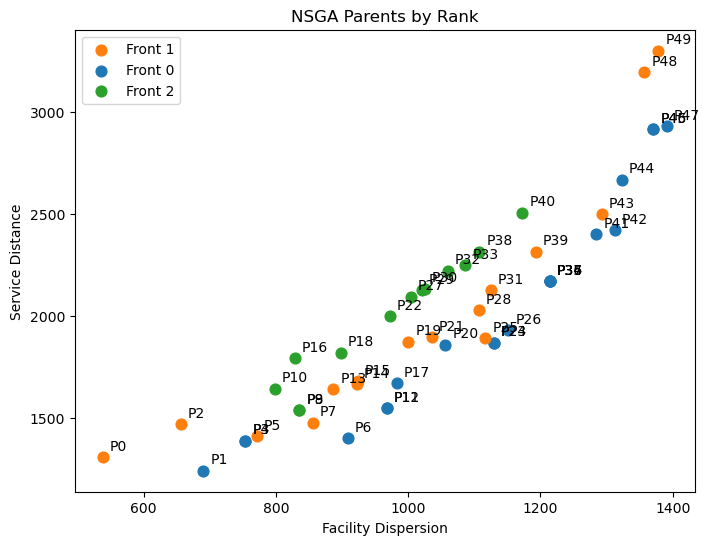

In [1203]:
plt.figure(figsize=(8, 6))
cmap = plt.get_cmap("tab10")

for i, s in enumerate(parents):
    rank = s.rank
    color = cmap(rank % 10)
    label = f"Front {rank}"

    # avoid duplicate legend entries
    if label not in plt.gca().get_legend_handles_labels()[1]:
        plt.scatter(
            s.facility_dispersion_score,
            s.service_distance_score,
            color=color,
            s=60,
            label=label
        )
    else:
        plt.scatter(
            s.facility_dispersion_score,
            s.service_distance_score,
            color=color,
            s=60
        )

    plt.annotate(
        f"P{i}",
        (s.facility_dispersion_score, s.service_distance_score),
        xytext=(5, 5),
        textcoords="offset points"
    )

plt.xlabel("Facility Dispersion")
plt.ylabel("Service Distance")
plt.title("NSGA Parents by Rank")
plt.legend()
plt.show()

### Visualize facility placements

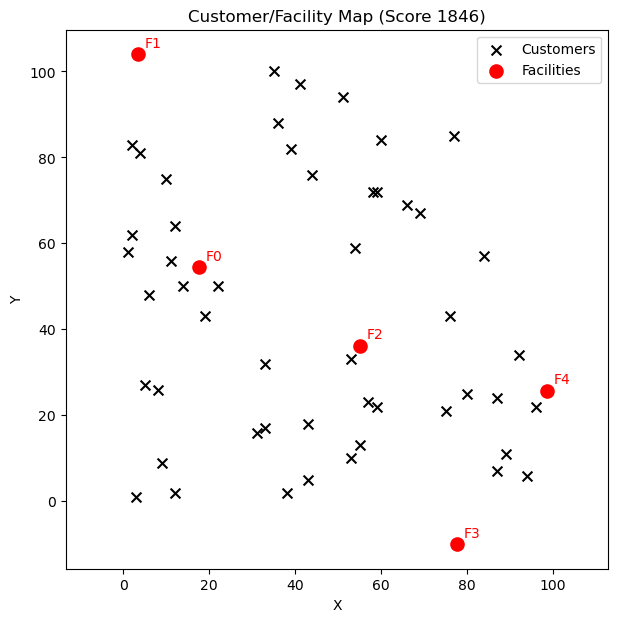

In [1204]:
plt.figure(figsize=(7, 7))

# plot customers
cx = [c.x for c in customers]
cy = [c.y for c in customers]
plt.scatter(cx, cy, marker="x", color="black", s=50, label="Customers")

# plot facilities
fx = [f.x for f in best_solution.facilities]
fy = [f.y for f in best_solution.facilities]
plt.scatter(fx, fy, marker="o", color="red", s=90, label="Facilities")

# annotate facilities
for i, f in enumerate(best_solution.facilities):
    plt.annotate(f"F{i}", (f.x, f.y), xytext=(5, 5), textcoords="offset points", color="red")

score = best_solution.service_distance_score + best_solution.facility_dispersion_score

plt.xlabel("X")
plt.ylabel("Y")
plt.title(f"Customer/Facility Map (Score {int(score)})")
plt.legend()
plt.axis("equal")
plt.show()